In [1]:
from pathlib import Path

import gin
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import asnumpy, parse_shape, rearrange

import dataloaders
from imageio.v3 import imread
import multi_slam.solver.epa_ops as epops
from multi_slam.locnet import LocNet
from multi_slam.utils.misc import clean_state_dict
from multi_slam.utils.drawing import make_matching_plot
from multi_slam.utils.keypoint_extractors import random_keypoints, superpoint_keypoints

In [2]:
# Helper functions

@torch.inference_mode()
def run_model(model, images, intrinsics):
    assert parse_shape(images, 'LR RGB _ _') == dict(LR=2, RGB=3)
    assert parse_shape(intrinsics, 'LR f') == dict(LR=2, f=4)
    fixed_output, model_output = model(images[None], intrinsics[None])
    output = []
    for mo in model_output:
        pts1, pts2 = epops.make_bidir_pts(fixed_output['centroids'], mo['matches']).squeeze(1)
        weights = mo['weight'].flatten()
        output.append([pts1, pts2, weights, mo['poses'].matrix()])
    return output

def show_img(x):
    plt.figure(figsize = (10,10))
    plt.imshow(x)
    plt.axis('off')
    plt.show()

In [3]:
gconfigs = [next(iter(Path('gconfigs').rglob(g)), None) for g in (["model/fast.gin"])]
assert all(gconfigs) # ensure all .gin files were found

gin.parse_config_files_and_bindings(gconfigs, []);

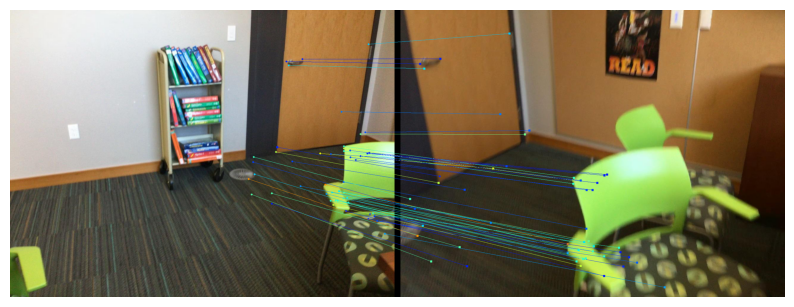

In [4]:
model_state = "twoview.pth"

# Set random seed
torch.manual_seed(1234)
np.random.seed(1234)

# Setup model
model = LocNet().cuda().eval()
model.load_state_dict(clean_state_dict(torch.load(model_state)))
# net.compile_modules()

PATH1 = "images/example_left.jpg"
PATH2 = "images/example_right.jpg"

image1 = torch.as_tensor(np.copy(imread(PATH1)))
image2 = torch.as_tensor(np.copy(imread(PATH2)))
images = torch.stack((image1, image2)).permute(0, 3, 1, 2).float().cuda()

intrinsics = torch.tensor([320, 320, 320, 240]).float().cuda().tile(2,1)

predictions = run_model(model, images, intrinsics)

_, _, final_weights, _ = predictions[-1]
matches_to_show = asnumpy(final_weights.argsort()[-50:])
img1, img2 = rearrange(asnumpy(images.byte()), 'LR RGB H W -> LR H W RGB', LR=2, RGB=3)
for step, (pts1, pts2, weights, pred_pose) in enumerate(predictions[-1:]):
    img = make_matching_plot(None, img1, img2, asnumpy(pts1), asnumpy(pts2), asnumpy(weights) * 3, matches_to_show, text=[])
    show_img(img)